# Analysis

Exploratory analysis on detecting reocurring stock price decreases.

In [22]:
import pandas as pd
import importlib
from matplotlib import pyplot as plt
import numpy as np
from datetime import date

import utils.utils as utils

### Load data

Data is found at https://finance.yahoo.com/quote/NRDY/history?filter=history

In [2]:
df = pd.read_csv("data/NRDY.csv")

print(df)


           Date    Open    High     Low   Close  Adj Close  Volume
0    2020-11-27   9.700   9.700   9.700   9.700      9.700     100
1    2020-11-30  10.250  10.270  10.250  10.270     10.270     400
2    2020-12-01  10.010  10.170   9.900  10.165     10.165   52800
3    2020-12-02  10.165  10.165  10.165  10.165     10.165       0
4    2020-12-03  10.670  10.670  10.590  10.590     10.590     600
..          ...     ...     ...     ...     ...        ...     ...
857  2024-04-26   2.650   2.835   2.620   2.760      2.760  899600
858  2024-04-29   2.770   2.820   2.660   2.710      2.710  700100
859  2024-04-30   2.670   2.680   2.580   2.590      2.590  560600
860  2024-05-01   2.610   2.660   2.530   2.560      2.560  900800
861  2024-05-02   2.630   2.660   2.480   2.640      2.640  826100

[862 rows x 7 columns]


### Cleaning data

Calculating change in stock price from close of one day to close of the next day.

In [3]:
importlib.reload(utils)

df = utils.clean_df(df)

df

,Date,Open,High,Low,Close,Adj Close,Volume,percent_chg
1,2020-11-30,10.250,10.270,10.250,10.270,10.270,400,0.058763
2,2020-12-01,10.010,10.170,9.900,10.165,10.165,52800,-0.010224
3,2020-12-02,10.165,10.165,10.165,10.165,10.165,0,0.000000
4,2020-12-03,10.670,10.670,10.590,10.590,10.590,600,0.041810
5,2020-12-04,10.360,10.480,10.350,10.400,10.400,1600,-0.017941
...,...,...,...,...,...,...,...,...
857,2024-04-26,2.650,2.835,2.620,2.760,2.760,899600,0.061538
858,2024-04-29,2.770,2.820,2.660,2.710,2.710,700100,-0.018116
859,2024-04-30,2.670,2.680,2.580,2.590,2.590,560600,-0.044280
860,2024-05-01,2.610,2.660,2.530,2.560,2.560,900800,-0.011583


### Pattern Analysis

Generating possible patterns and calculating their percentage of days the price decreased, the mean of the percent price change, and the standard deviation of the price change.

In [4]:
importlib.reload(utils)

patterns = utils.generate_possible_patterns(df)

evaluation_dict = {"pattern": [], "days_decreased": [], "days_total": [], "mean": [], "stdev": []}
for pattern in patterns:
  days_decreased, mean, stdev = utils.evaluate_pattern(pattern, df)
  days_total = len(pattern)

  evaluation_dict["pattern"].append(pattern)
  evaluation_dict["days_decreased"].append(days_decreased)
  evaluation_dict["days_total"].append(days_total)
  evaluation_dict["mean"].append(mean)
  evaluation_dict["stdev"].append(stdev)

evaluation_df = pd.DataFrame(evaluation_dict)

evaluation_df

,pattern,days_decreased,days_total,mean,stdev
0,"[2020-11-30, 2021-03-01, 2021-06-01, 2021-08-3...",7,14,0.015215,0.058144
1,"[2020-12-01, 2021-03-01, 2021-06-01, 2021-09-0...",6,14,0.025985,0.083139
2,"[2020-12-02, 2021-03-02, 2021-06-02, 2021-09-0...",9,14,-0.007554,0.026971
3,"[2020-12-03, 2021-03-03, 2021-06-03, 2021-09-0...",9,14,-0.015165,0.034902
4,"[2020-12-04, 2021-03-04, 2021-06-04, 2021-09-0...",11,14,-0.016676,0.030082
...,...,...,...,...,...
856,[2024-04-26],0,1,0.061538,0.000000
857,[2024-04-29],1,1,-0.018116,0.000000
858,[2024-04-30],1,1,-0.044280,0.000000
859,[2024-05-01],1,1,-0.011583,0.000000


#### Cleaning Evaluations

We need to remove patterns with less than 4 dates, or 1 year, as they do not have enough data points to show a pattern.


In [5]:
evaluation_df = evaluation_df[evaluation_df["pattern"].apply(len) >= 4]
evaluation_df

,pattern,days_decreased,days_total,mean,stdev
0,"[2020-11-30, 2021-03-01, 2021-06-01, 2021-08-3...",7,14,0.015215,0.058144
1,"[2020-12-01, 2021-03-01, 2021-06-01, 2021-09-0...",6,14,0.025985,0.083139
2,"[2020-12-02, 2021-03-02, 2021-06-02, 2021-09-0...",9,14,-0.007554,0.026971
3,"[2020-12-03, 2021-03-03, 2021-06-03, 2021-09-0...",9,14,-0.015165,0.034902
4,"[2020-12-04, 2021-03-04, 2021-06-04, 2021-09-0...",11,14,-0.016676,0.030082
...,...,...,...,...,...
667,"[2023-07-27, 2023-10-27, 2024-01-29, 2024-04-29]",2,4,0.001495,0.014142
668,"[2023-07-28, 2023-10-30, 2024-01-29, 2024-04-29]",1,4,0.031834,0.046183
669,"[2023-07-31, 2023-10-31, 2024-01-31, 2024-04-30]",3,4,-0.015192,0.023022
670,"[2023-08-01, 2023-11-01, 2024-02-01, 2024-05-01]",2,4,-0.004814,0.013526


#### Visualizations

Creating visualizations for the evaluations.

First, creating a histogram to visualize the distribution of days_decreased / days_total

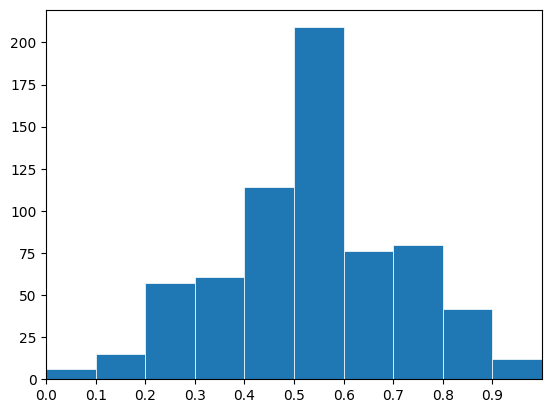

In [15]:
# organize data
x = (evaluation_df["days_decreased"] / evaluation_df["days_total"]).to_list()

# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=10, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 1), xticks=np.arange(0, 1, .1))

plt.show()

Results of this graph show that there are some patterns that have consistently decreases. However, this is expected due to probability. We need a way to differentiate between the real patterns and those that are random.

Next, we can visualize the correlation of means and percentage of days decreased. We expect to see a negative correlation. We can plot the real patterns in red to compare with the rest.

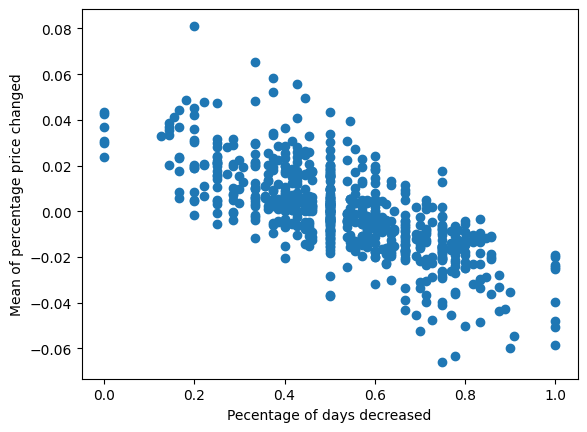

In [21]:
# organize data
x = (evaluation_df["days_decreased"] / evaluation_df["days_total"]).to_list()
y = evaluation_df["mean"].to_list()

# plot:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel("Pecentage of days decreased")
ax.set_ylabel("Mean of percentage price changed")

# real patterns
# start_date = date("")
# for pattern in patterns:
#   if patterns

plt.show()